In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
plt.rcParams["figure.figsize"] = (10,10)

In [3]:
df_full = pd.read_csv("data/source/train_data.csv")

In [4]:
df_full.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0


In [5]:
# shift time to the start of the period
df_full["timestamp"] -= df_full["timestamp"].min()
# translate time to hours
df_full["timestamp"] /= 60 * 60

In [6]:
df_full.describe()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt
count,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06,8.526526e+06
mean,5.114566e+03,3.005684e+01,5.941014e+01,1.073289e+02,4.281519e+00,2.935381e+02,2.227026e+01,4.969738e+00,2.337222e-01,1.596899e-02,3.001426e+00
std,2.631255e+03,2.851339e+00,5.582277e+00,3.120410e+03,6.927234e+01,4.169500e+02,3.842956e+01,8.166667e+00,9.078254e-01,1.590046e-01,5.725451e+00
min,0.000000e+00,-4.841021e+01,-1.390007e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.989000e+03,3.028221e+01,5.992136e+01,1.700000e+01,0.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.326000e+03,3.031590e+01,5.993486e+01,3.700000e+01,1.000000e+00,1.160000e+02,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,7.316000e+03,3.035632e+01,5.995961e+01,7.400000e+01,3.000000e+00,4.010000e+02,2.500000e+01,6.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
max,9.503000e+03,1.371368e+02,6.037409e+01,8.700346e+06,1.111460e+05,2.200000e+03,4.860000e+02,2.340000e+02,9.200000e+01,3.600000e+01,1.099000e+03


#### Total number of polygons

In [7]:
locations = np.unique(df_full[["lon", "lat"]], axis=0)
location_to_index = {(loc[0], loc[1]): i for i, loc in enumerate(locations)}
len(locations)

7041

##### General overview of location

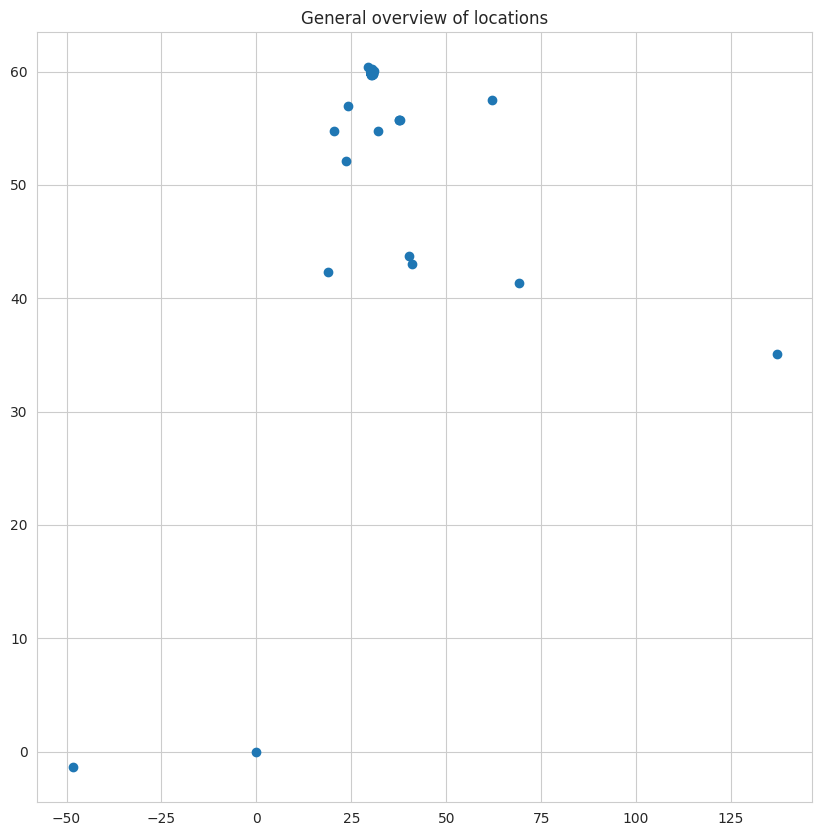

In [8]:
plt.plot(locations[:, 0], locations[:, 1], 'o')
plt.title("General overview of locations")
plt.show()

There is one location with many points, and there are also several single points.

For example, let's consider St.Petersburg (location with many points)

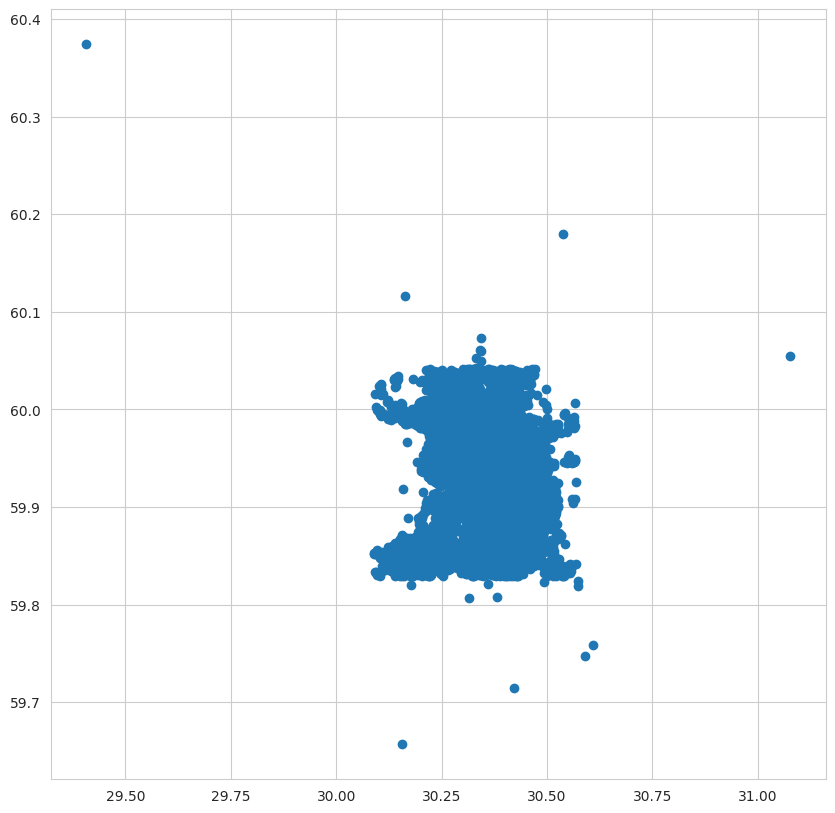

In [9]:
size = 10
x, y = 30.4, 59.9
part = locations[(locations[:, 0] <= x + size / 2) &
                 (locations[:, 0] >= x - size / 2) &
                 (locations[:, 1] <= y + size / 2) &
                 (locations[:, 1] >= y - size / 2)]
plt.plot(part[:, 0], part[:, 1], 'o')
plt.show()

Let us know, how big are other locations

[-1  0]


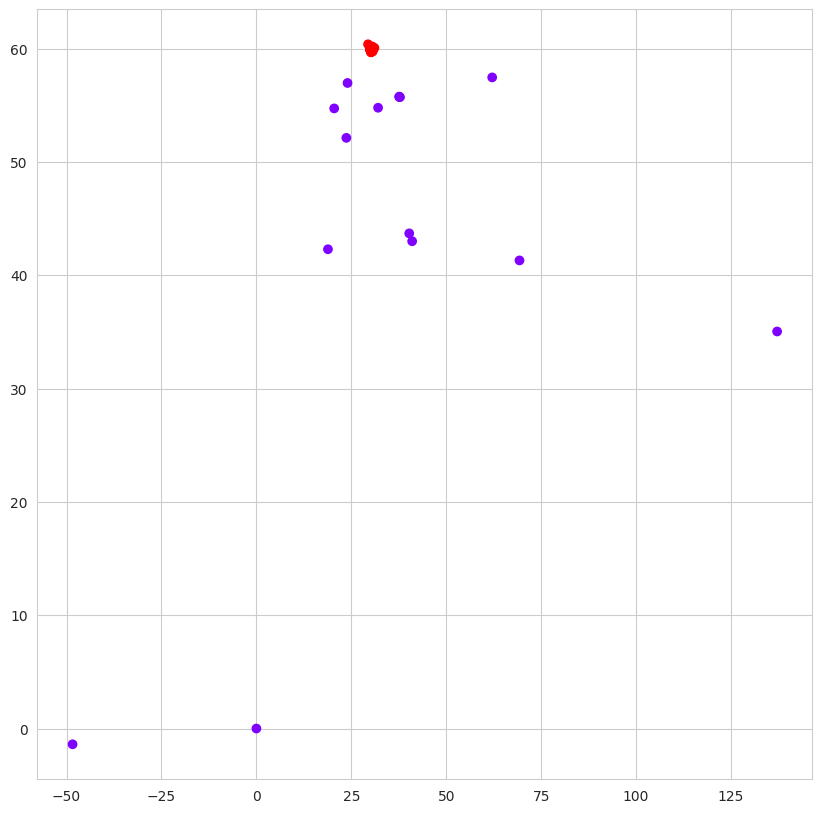

In [10]:
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm

clustering = DBSCAN(eps=2, min_samples=4)
labels = clustering.fit_predict(locations)
print(np.unique(labels))

colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
plt.scatter(locations[:, 0], locations[:, 1], color=[colors[i + 1] for i in labels])
plt.show()

We see that only St.Petersburg region has more than 3 cells. Let us investigate how much activity there is in other locations.

In [11]:
for i, label in enumerate(labels):
    if label != -1:
        continue
    x, y = locations[i]
    loc_df = df_full[(df_full["lon"] == x) & (df_full["lat"] == y)]
    part = len(loc_df) / len(df_full) * 100
    print("Location ({:8.4f}, {:8.4f}) contains {:5} messages which is {:6.3f}% of all messages".format(y, x, len(loc_df), part))


Location ( -1.3900, -48.4102) contains   107 messages which is  0.001% of all messages
Location (  0.0000,   0.0000) contains 74415 messages which is  0.873% of all messages
Location ( 42.2899,  18.8467) contains    15 messages which is  0.000% of all messages
Location ( 54.7150,  20.4861) contains     1 messages which is  0.000% of all messages
Location ( 52.1167,  23.6908) contains   335 messages which is  0.004% of all messages
Location ( 56.9590,  24.0007) contains    16 messages which is  0.000% of all messages
Location ( 54.7746,  32.0474) contains     4 messages which is  0.000% of all messages
Location ( 55.7586,  37.6214) contains    32 messages which is  0.000% of all messages
Location ( 55.7219,  37.6394) contains    21 messages which is  0.000% of all messages
Location ( 55.7080,  37.8123) contains     2 messages which is  0.000% of all messages
Location ( 43.6894,  40.2513) contains     1 messages which is  0.000% of all messages
Location ( 42.9969,  41.0216) contains   85

In [12]:
print(f"Number of single locations: {np.abs(np.sum(labels))}")

Number of single locations: 15


We will not consider these locations as they have very low activity comparing to St.Petersburg. If we need to predict this values, than we can take mean value of post for each such locations and that's it.
However, we think that it is important to consider (0, 0) location as it looks like it is a default location
for messages with unknown location.

#### Investigate location (0,0)

In [13]:
df = df_full.copy()
df["label"] = [labels[location_to_index[(loc[0], loc[1])]] for loc in df_full[["lon", "lat"]].values]
df = df[df["label"] == 0].reset_index()
df["count"] = 1
df.describe()

,index,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,label,count
count,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8.450632e+06,8450632.0,8450632.0
mean,4.263627e+06,5.120060e+03,3.032078e+01,5.993631e+01,1.071372e+02,4.277259e+00,2.931261e+02,2.223388e+01,4.965741e+00,2.332640e-01,1.594520e-02,2.996399e+00,0.0,1.0
std,2.461146e+06,2.631043e+03,7.437129e-02,4.500485e-02,3.133518e+03,6.950497e+01,4.166935e+02,3.840202e+01,8.163083e+00,9.075933e-01,1.590469e-01,5.706811e+00,0.0,0.0
min,0.000000e+00,0.000000e+00,2.940635e+01,5.965693e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0
25%,2.132435e+06,2.994000e+03,3.028670e+01,5.992136e+01,1.700000e+01,0.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0
50%,4.263836e+06,5.341000e+03,3.031814e+01,5.993599e+01,3.600000e+01,1.000000e+00,1.160000e+02,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.0,1.0
75%,6.394746e+06,7.327000e+03,3.035632e+01,5.995961e+01,7.400000e+01,3.000000e+00,4.000000e+02,2.500000e+01,6.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.0,1.0
max,8.526525e+06,9.503000e+03,3.107722e+01,6.037409e+01,8.700346e+06,1.111460e+05,2.200000e+03,4.860000e+02,2.340000e+02,9.200000e+01,3.600000e+01,1.099000e+03,0.0,1.0


In [14]:
df_zero = df_full[(df_full["lon"] == 0) & (df_full["lat"] == 0)].copy().reset_index()
df_zero["count"] = 1
df_zero.describe()

,index,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,count
count,7.441500e+04,74415.000000,74415.0,74415.0,74415.000000,74415.000000,74415.000000,74415.000000,74415.000000,74415.000000,74415.000000,74415.000000,74415.0
mean,4.227761e+06,4534.214984,0.0,0.0,129.023906,4.749929,342.556514,26.574185,5.445206,0.287738,0.018907,3.592340,1.0
std,2.490027e+06,2570.219089,0.0,0.0,787.128118,34.982989,443.532523,41.320451,8.559404,0.938346,0.155459,7.545354,0.0
min,2.130000e+02,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2.047896e+06,2514.000000,0.0,0.0,18.000000,0.000000,34.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,4.192361e+06,4075.000000,0.0,0.0,39.000000,1.000000,167.000000,8.000000,1.000000,0.000000,0.000000,1.000000,1.0
75%,6.422322e+06,6805.000000,0.0,0.0,81.000000,3.000000,481.000000,34.000000,7.000000,0.000000,0.000000,4.000000,1.0
max,8.525938e+06,9503.000000,0.0,0.0,82782.000000,4588.000000,2200.000000,386.000000,59.000000,30.000000,7.000000,1096.000000,1.0


#### Aggregated post dataframe

In [15]:
df = df.groupby(["lon", "lat", "timestamp"]).agg({
    "count":"sum",
    "likescount": np.mean,
    "commentscount": np.mean,
    "symbols_cnt": np.mean,
    "words_cnt": np.mean,
    "hashtags_cnt": np.mean,
    "mentions_cnt": np.mean,
    "links_cnt": np.mean,
    "emoji_cnt": np.mean,
}).reset_index()

In [16]:
df.head()

,lon,lat,timestamp,count,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt
0,29.406351,60.37409,3641.0,1,16.0,0.0,15.0,3.0,0.0,0.0,0.0,1.0
1,29.406351,60.37409,3667.0,1,33.0,0.0,103.0,10.0,0.0,0.0,0.0,2.0
2,29.406351,60.37409,4519.0,1,48.0,0.0,85.0,9.0,0.0,0.0,0.0,2.0
3,29.406351,60.37409,4817.0,1,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,29.406351,60.37409,5492.0,1,58.0,0.0,6.0,0.0,0.0,0.0,0.0,3.0


In [17]:
max_time = int(df["timestamp"].max())
max_time

9503

Let's see some examples of time series, sample 10 polygons

In [18]:
def plot_time_series(data, title):
    counts = [0] * (max_time + 1)
    times = list(range(max_time + 1))
    for t, c in data[["timestamp", "count"]].values:
        counts[int(t)] = c
    plt.figure(figsize=(40, 5))
    plt.plot(times, counts)
    plt.title(title)
    plt.show()

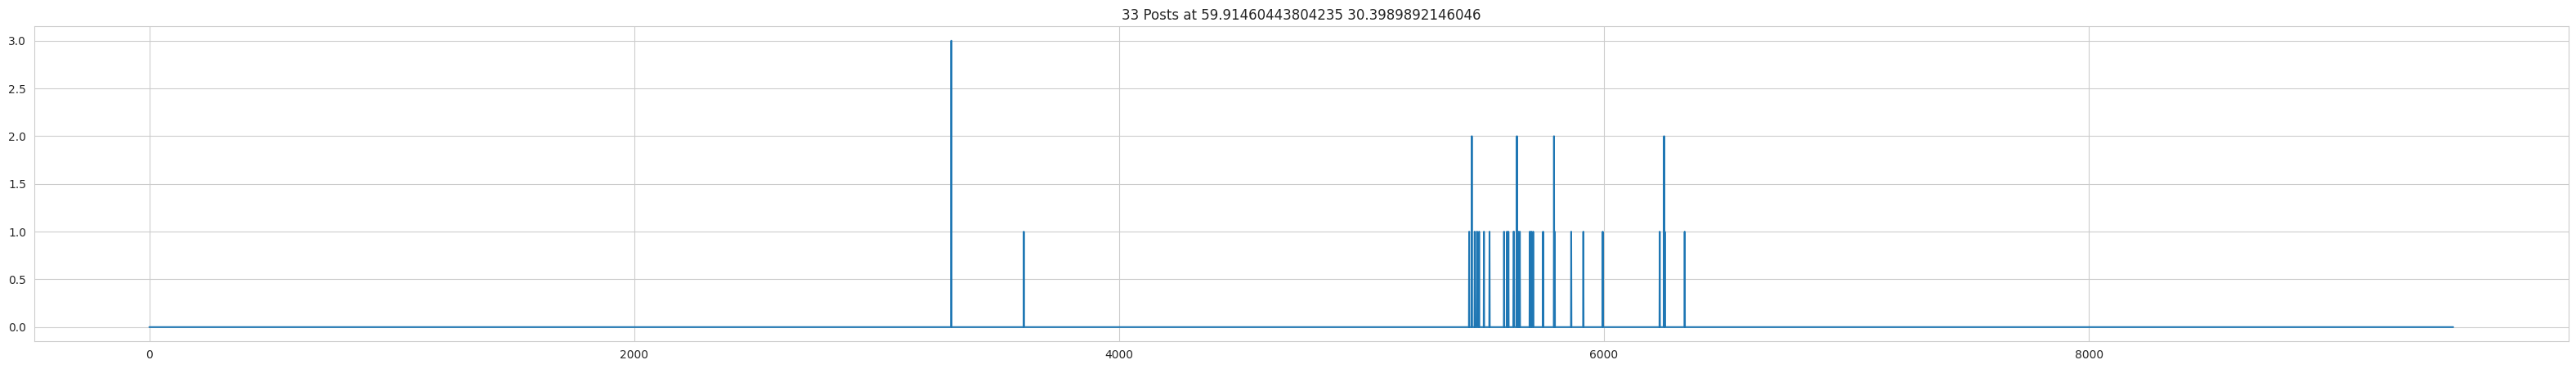

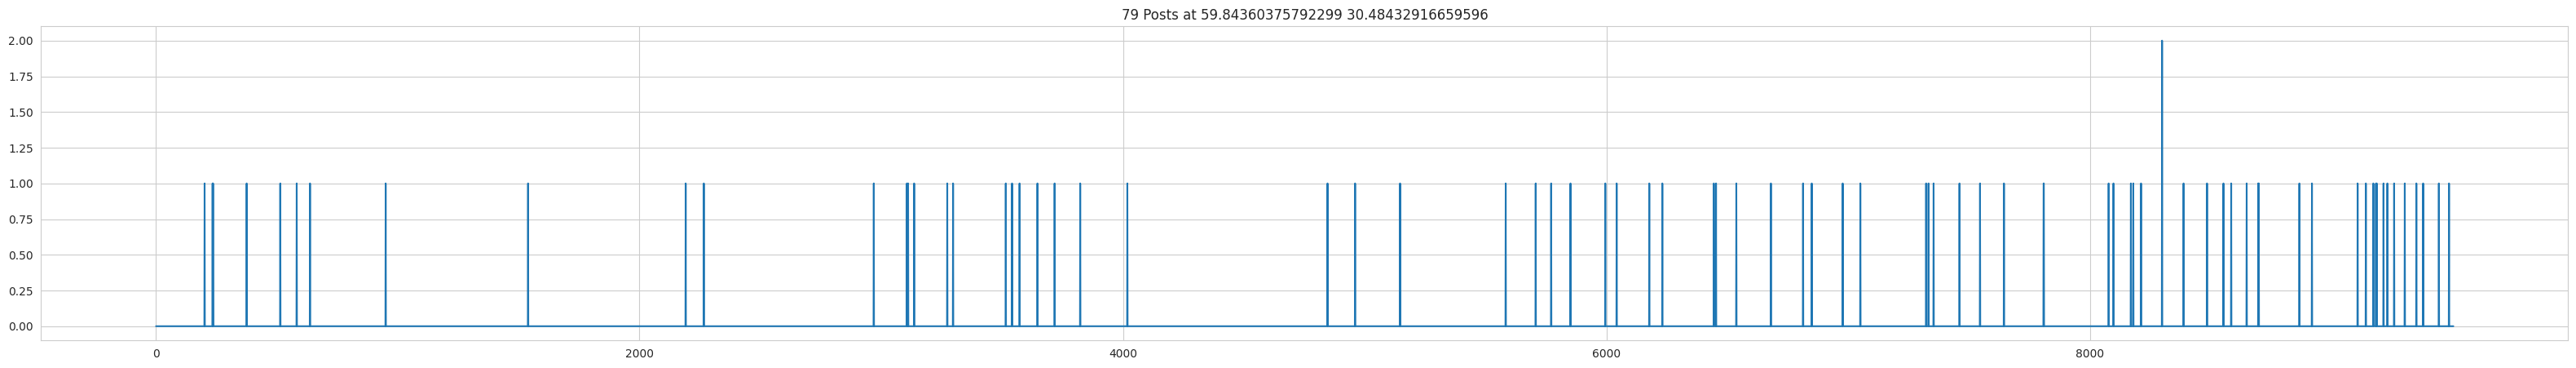

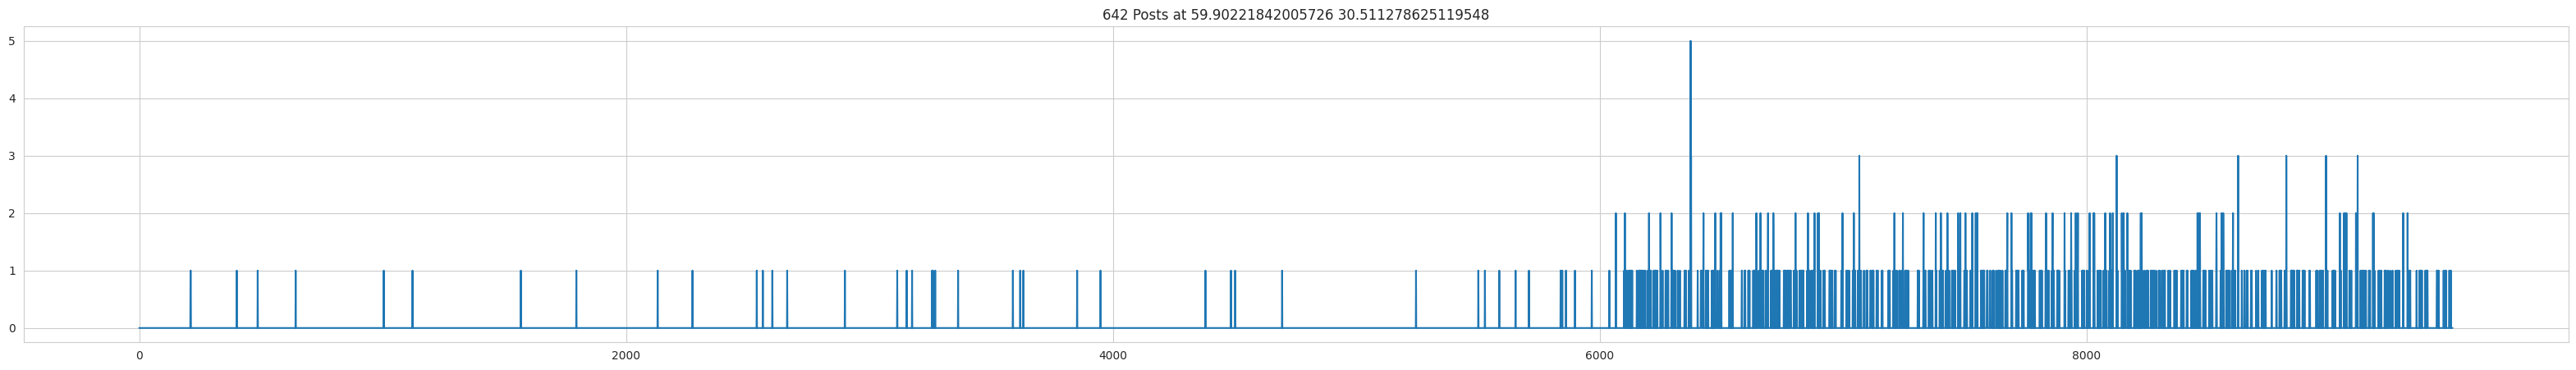

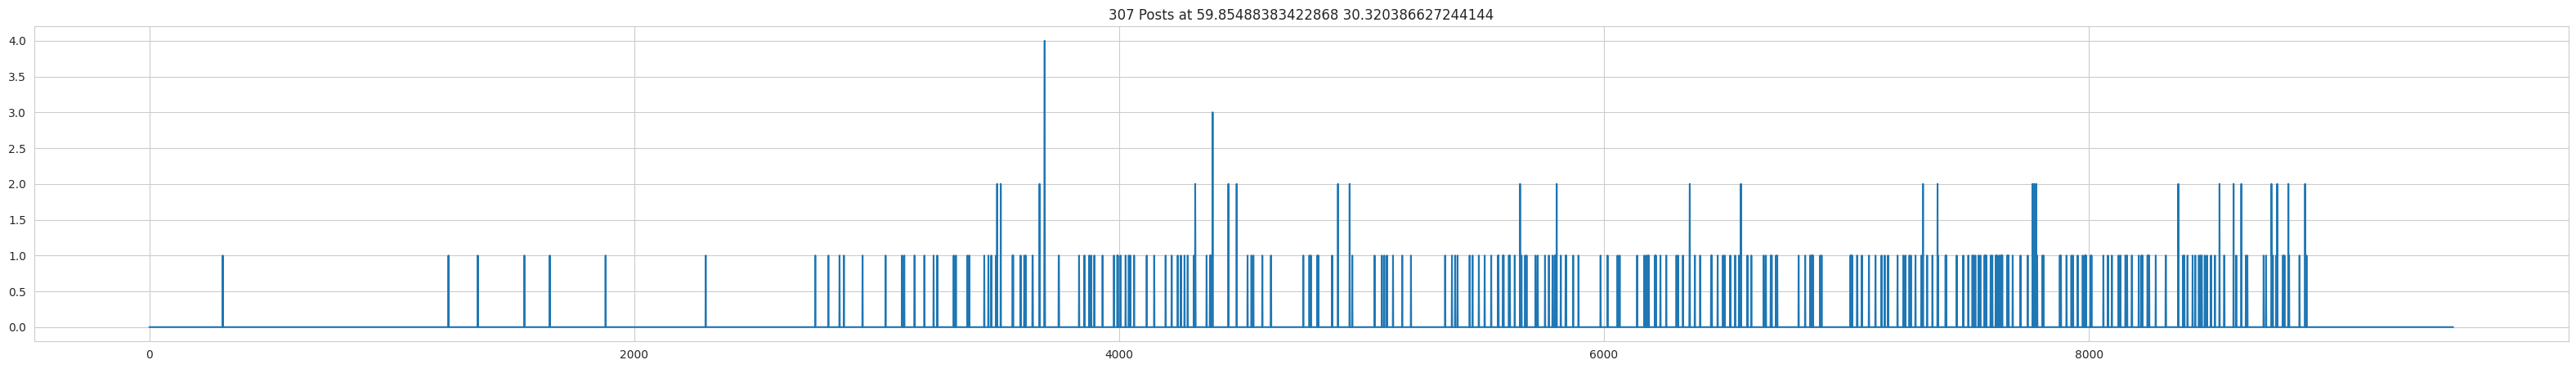

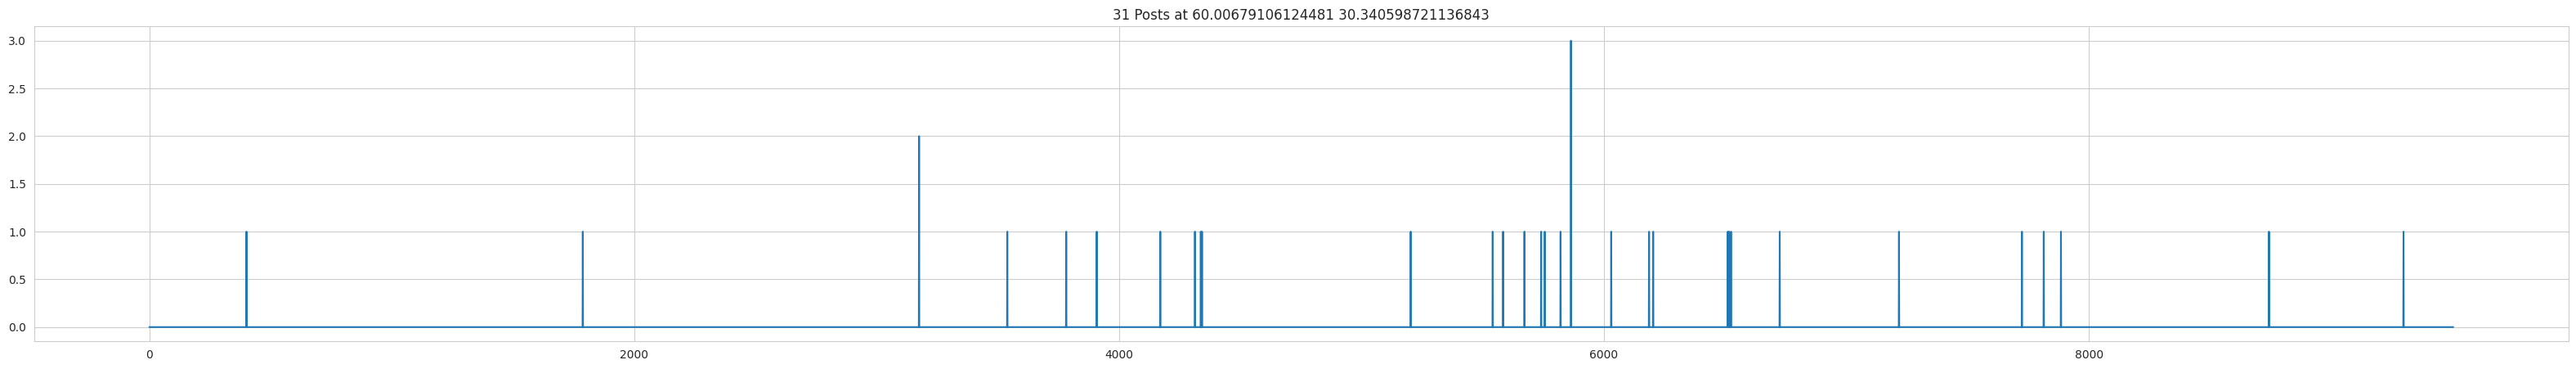

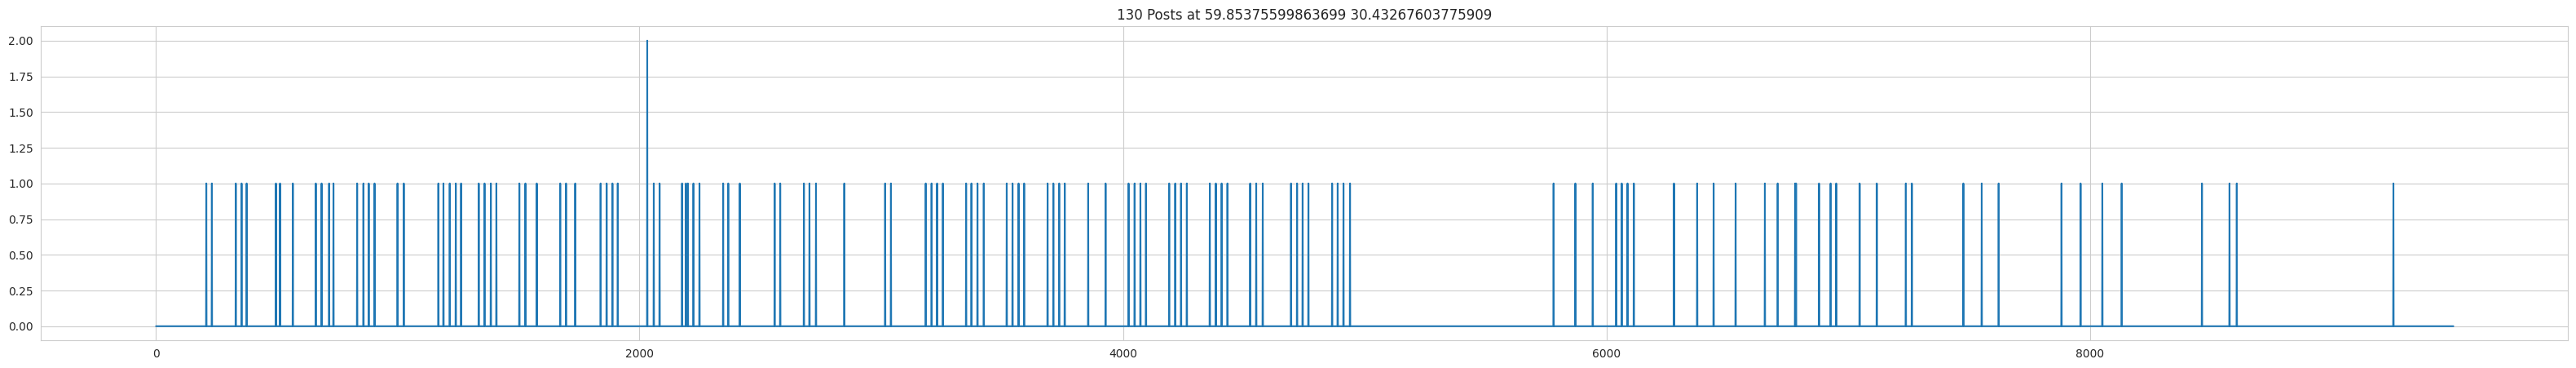

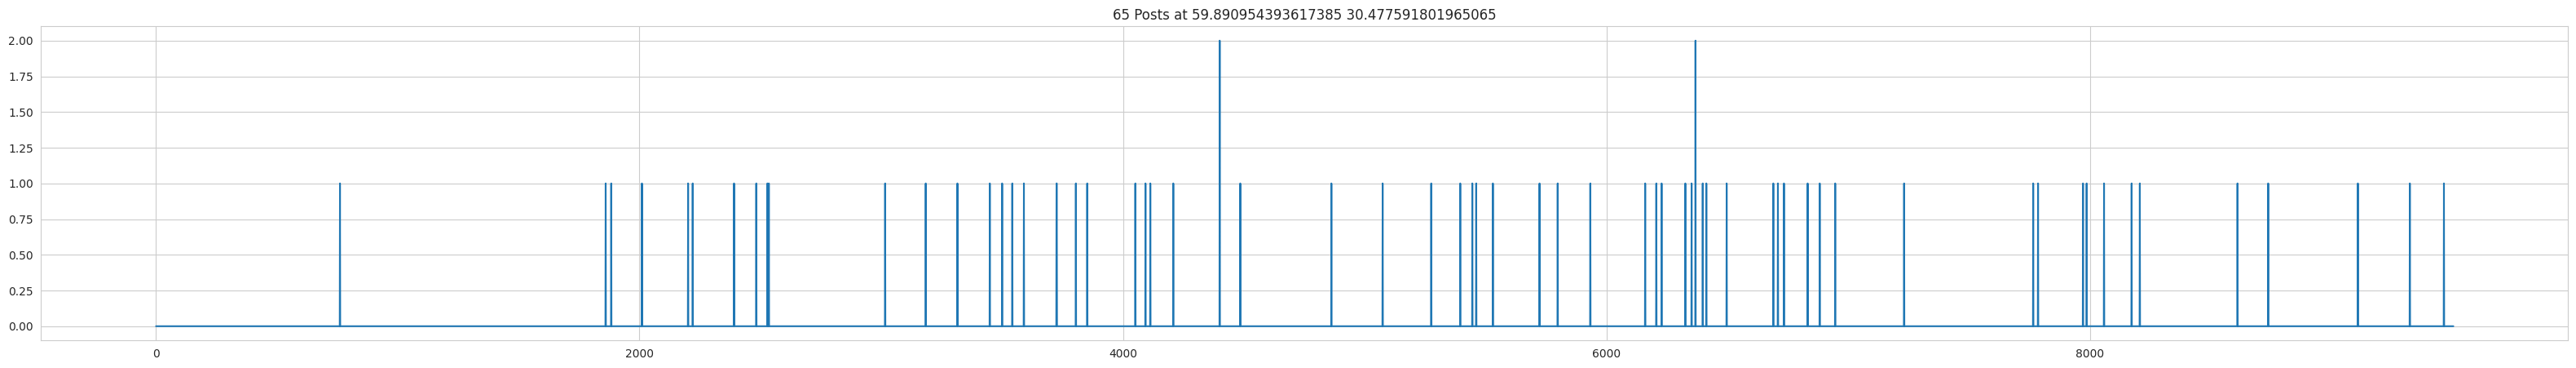

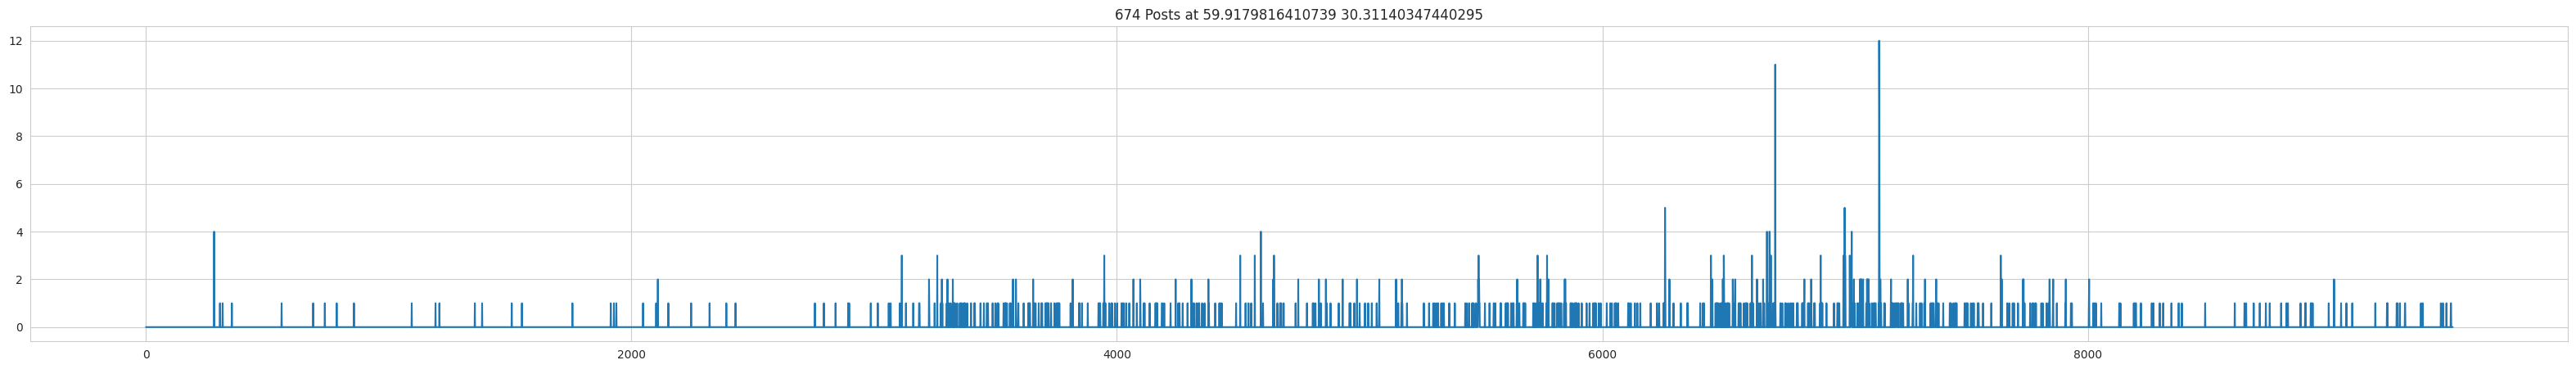

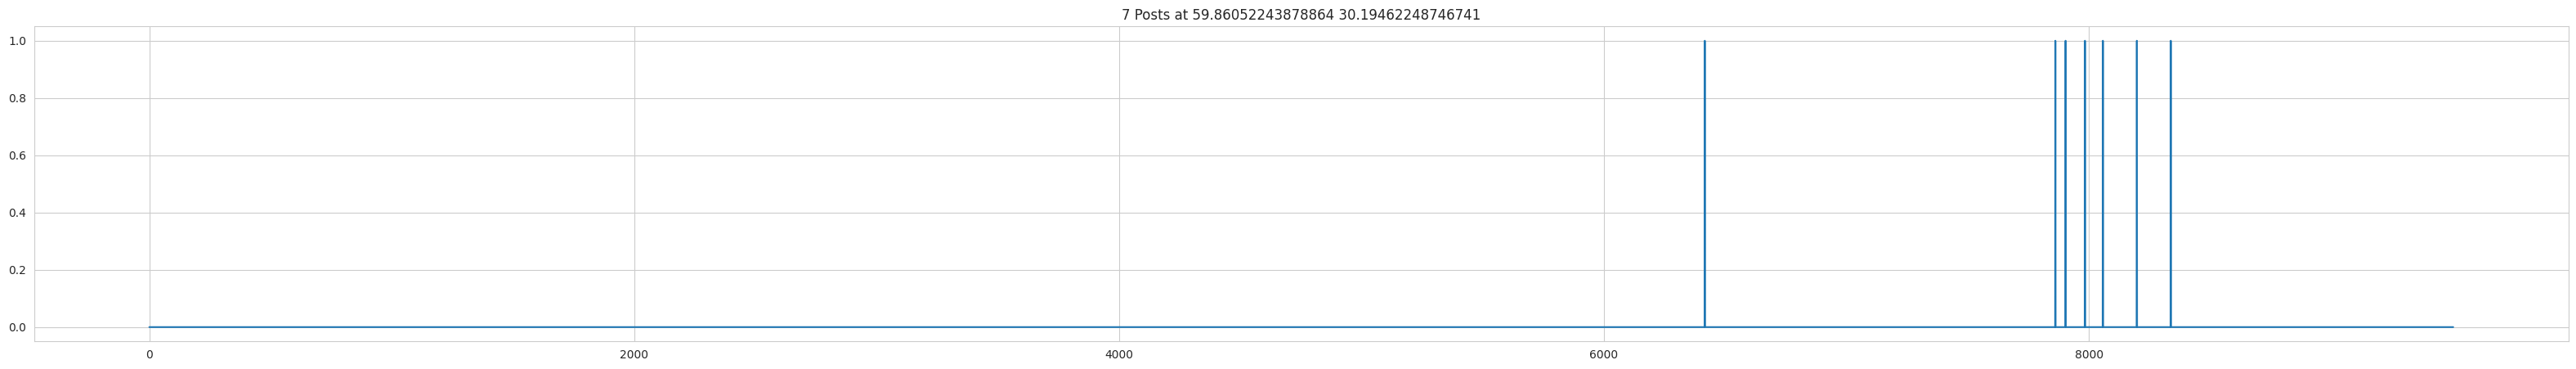

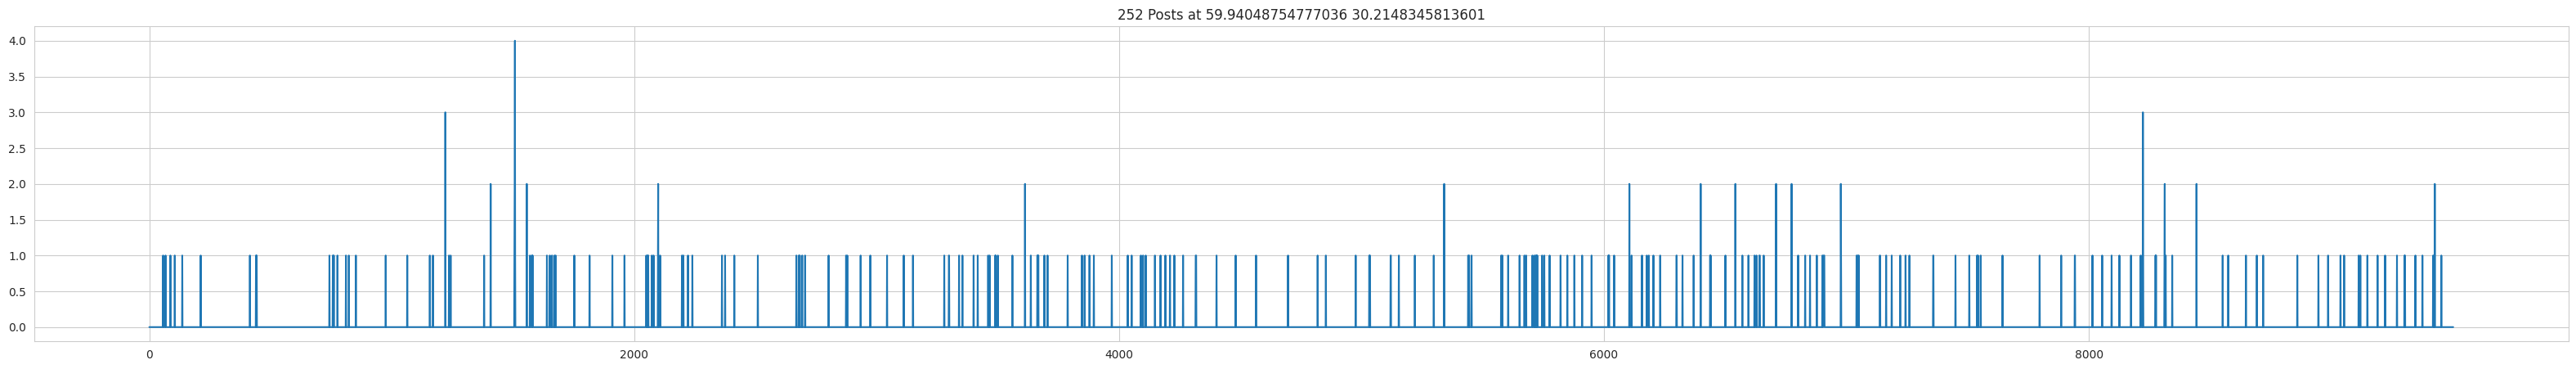

In [19]:
locations = np.unique(df[["lon", "lat"]], axis=0)
np.random.seed(42)
random_sample = np.random.choice(list(range(len(locations))), 10, replace=False)

for loc in [locations[i] for i in random_sample]:
    loc_df = df[(df["lon"] == loc[0]) & (df["lat"] == loc[1])]
    plot_time_series(loc_df, "{} Posts at {} {}".format(len(loc_df), loc[1], loc[0]))

#### Check the number of posts for each cell over time

In [20]:
counts_per_cell = df.groupby(["lon", "lat"]).agg({"count": "sum"})

In [21]:
counts_per_cell.describe()

,count
count,7026.000000
mean,1202.765727
std,5833.637091
min,1.000000
25%,16.000000
50%,82.000000
75%,398.000000
max,196054.000000


Well, mean=1200 posts for the 9503 (max_time) times is totally not enough :(

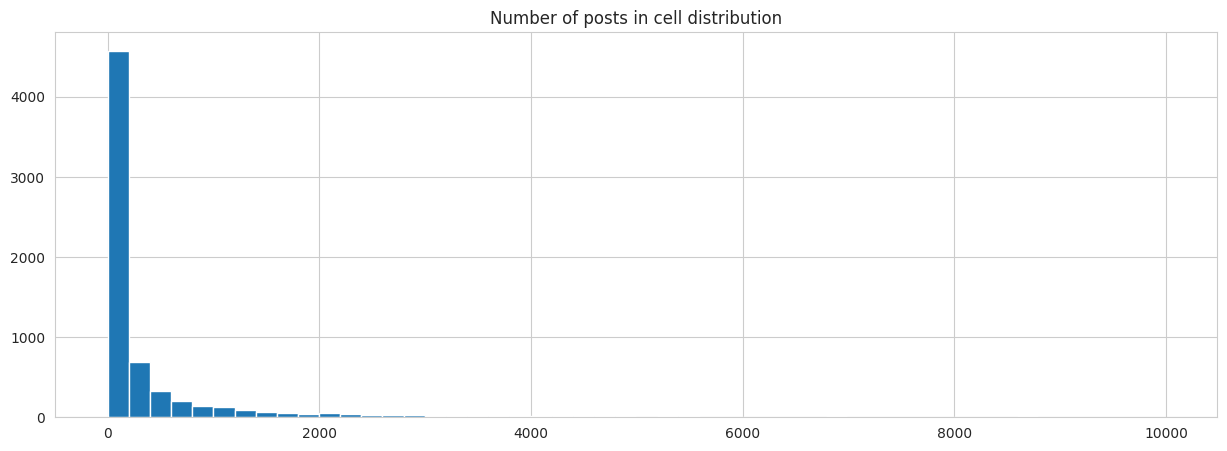

In [22]:
counts_per_cell = counts_per_cell[counts_per_cell["count"] < 10000] ## THERE ARE SEVERAL LOCATIONS WITH TOO MANY POSTS
counts_per_cell = counts_per_cell["count"].values
plt.figure(figsize=(15, 5))
plt.hist(counts_per_cell, bins = 50)
plt.title("Number of posts in cell distribution")
plt.show()

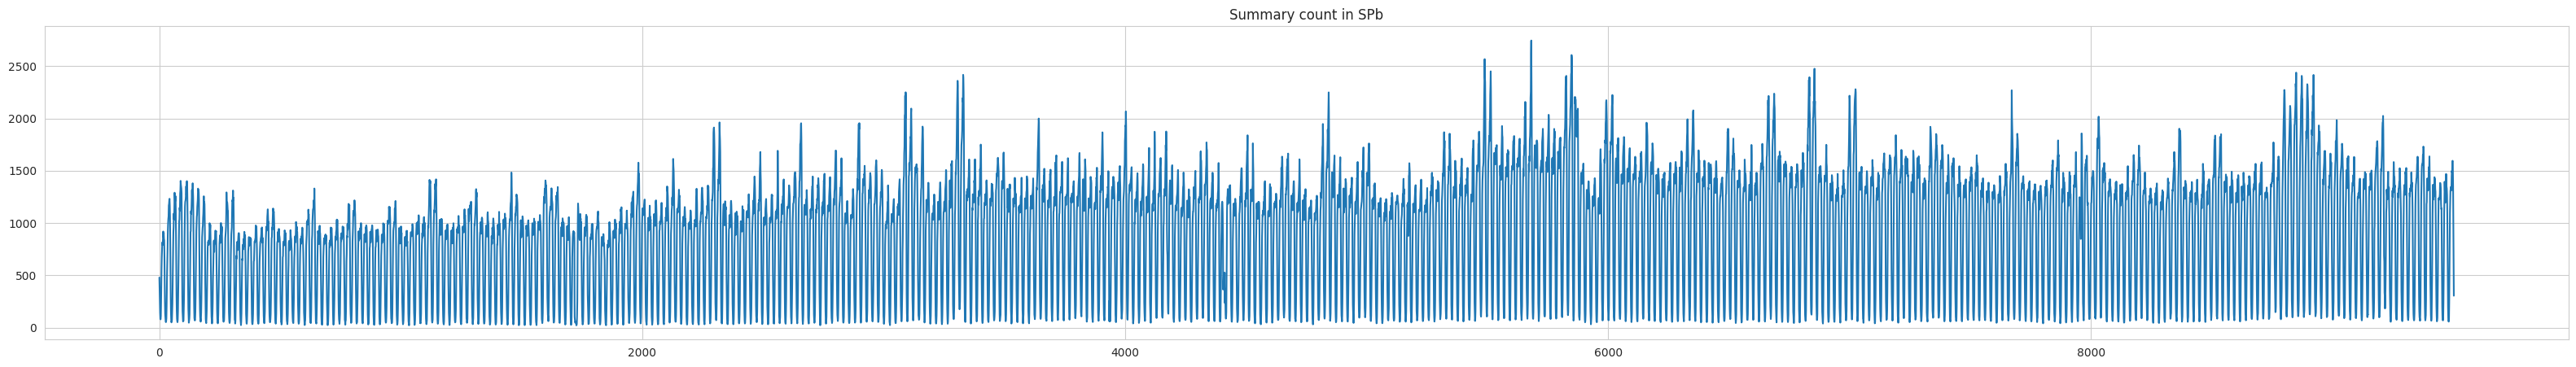

In [23]:
df_avg = df.groupby("timestamp").agg({"count": "sum"}).reset_index()
plot_time_series(df_avg, "Summary count in SPb")

#### Try to show number of post over the time on heatmap

In [24]:
counts_per_cell = df.groupby(["lon", "lat"]).agg({"count": "sum"}).reset_index()
counts_per_cell.head()

,lon,lat,count
0,29.406351,60.374090,58
1,30.089070,59.851500,52
2,30.089070,59.852628,1
3,30.091316,59.833448,138
4,30.091316,59.851500,2


In [25]:
counts_per_cell["lon"] = (counts_per_cell["lon"] * 1e15).apply(lambda x: int(x))
counts_per_cell["lat"] = (counts_per_cell["lat"] * 1e15).apply(lambda x: int(x))
counts_per_cell = counts_per_cell.astype({"lon": int, "lat": int})
counts_per_cell.head()

,lon,lat,count
0,29406350825652532,60374089897957776,58
1,30089070441583372,59851500212767008,52
2,30089070441583372,59852628124816728,1
3,30091316229793676,59833448420068856,138
4,30091316229793676,59851500212767008,2


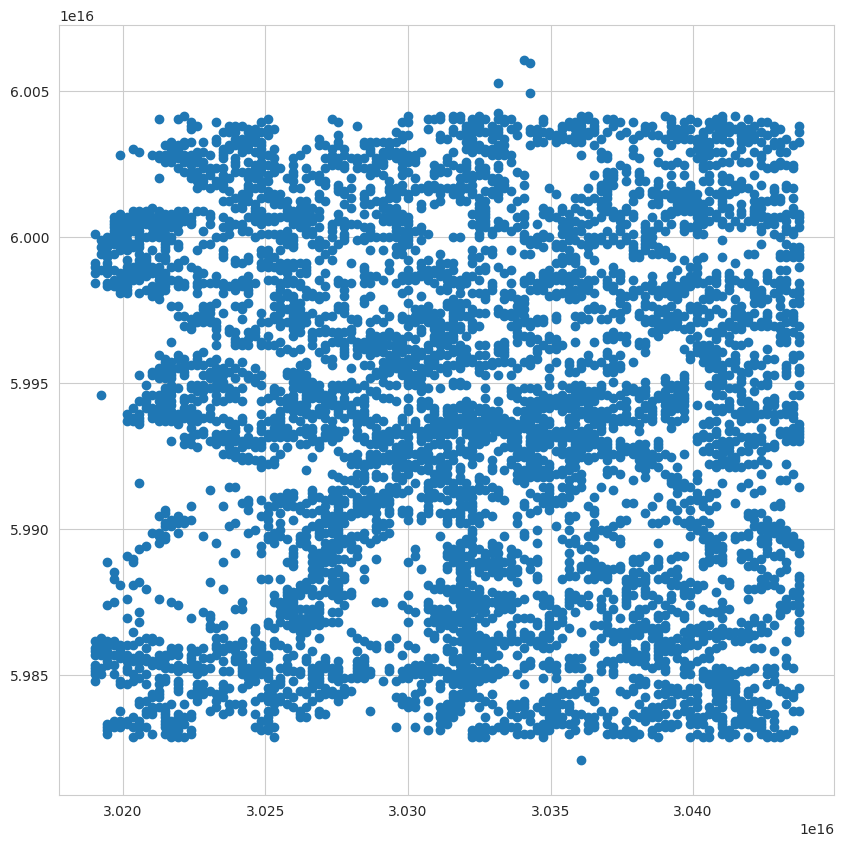

In [26]:
size = 0.25 * 1e15
spb_lon, spb_lat = 30.3141 * 1e15, 59.9386 * 1e15
counts_per_cell = counts_per_cell[(counts_per_cell["lon"] <= spb_lon + size / 2.0) &
                 (counts_per_cell["lon"] >= spb_lon - size / 2.0) &
                 (counts_per_cell["lat"] <= spb_lat + size / 2.0) &
                 (counts_per_cell["lat"] >= spb_lat - size / 2.0)]
plt.plot(counts_per_cell["lon"], counts_per_cell["lat"], 'o')
plt.show()

In [27]:
counts_per_cell.nunique()

lon       111
lat       196
count    1609
dtype: int64

In [28]:
counts_per_cell["count"].value_counts()

1       247
2       169
3       120
4        97
6        68
       ... 
961       1
6603      1
572       1
4117      1
9833      1
Name: count, Length: 1609, dtype: int64

In [29]:
counts_per_cell = counts_per_cell.sort_values(by=["lon", "lat"])
counts_per_cell.head()

,lon,lat,count
401,30190130911046812,59848116247232768,31
402,30190130911046812,59850372262487040,19
403,30190130911046812,59851500212767008,53
404,30190130911046812,59852628124816728,40
405,30190130911046812,59853755998636992,83


In [30]:
min_lon_diff = np.min(np.diff(counts_per_cell["lon"].unique()))
min_lon_diff

2245788210284

In [31]:
min_lat_diff = np.min(np.diff(counts_per_cell["lat"].sort_values().unique()))
min_lat_diff

1120854251368

For some reason min longitude diff is x2 as latitude diff. Why? Task description says that we have polygons 250х250 meters (???)
But ok

In [32]:
test = counts_per_cell["lon"].diff().value_counts().reset_index().values

In [33]:
print(list(zip(*test))[0])

(0.0, 2245788210300.0, 2245788210296.0, 2245788210304.0, 2245788210292.0, 2245788210308.0, 2245788210288.0, 2245788210284.0)


In [34]:
test2 = counts_per_cell["lat"].sort_values().diff().value_counts().reset_index().values

In [35]:
print(list(zip(*test2))[0])

(0.0, 1123635698112.0, 1124017076184.0, 1123978934512.0, 1123940793696.0, 1123902653712.0, 1123864514608.0, 1123826376392.0, 1123788238992.0, 1123750102488.0, 1123711966824.0, 1123673832032.0, 7901808706840.0, 1124055218752.0, 1123559432840.0, 1123521301472.0, 1123483171008.0, 1123445041368.0, 1123406912648.0, 1123368784704.0, 1123330657696.0, 1123292531536.0, 1123254406200.0, 1123216281768.0, 1123597565024.0, 1124093362160.0, 1124131506432.0, 1124589304904.0, 1124932735136.0, 1124894572792.0, 1124856411272.0, 1124818250656.0, 1124780090856.0, 1124741931976.0, 1124703773872.0, 1124665616720.0, 1124627460384.0, 1124551150272.0, 1124169651568.0, 1124512996544.0, 1124474843656.0, 1124436691640.0, 1124398540456.0, 1124360390168.0, 1124322240696.0, 1124284092144.0, 1124245944424.0, 1124207797560.0, 1123178158176.0, 1123140035440.0, 1123101913600.0, 1123063792616.0, 1122111048040.0, 1122072949488.0, 1122034851752.0, 1121996754936.0, 1121958658968.0, 1121920563832.0, 1121882469608.0, 11218443

Haha! There are no regular grid! So let's use simple cartesian product of existing lon and lat coords and make heatmap with it,
but of course we loose all topology of data

In [36]:
len(counts_per_cell["lon"].unique())

111

In [37]:
len(counts_per_cell["lat"].unique())

196

In [38]:
cartesian_prod_lon_lat = list(map(list, zip(*itertools.product(counts_per_cell["lon"].unique(), counts_per_cell["lat"].unique()))))
cartesian_prod_lon_lat

[[30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911046812,
  30190130911

In [39]:
len(cartesian_prod_lon_lat[0])

21756

In [40]:
df_heatmap = pd.DataFrame({"lon": cartesian_prod_lon_lat[0], "lat":cartesian_prod_lon_lat[1]})
df_heatmap.head()

,lon,lat
0,30190130911046812,59848116247232768
1,30190130911046812,59850372262487040
2,30190130911046812,59851500212767008
3,30190130911046812,59852628124816728
4,30190130911046812,59853755998636992


In [41]:
df_heatmap.nunique()

lon    111
lat    196
dtype: int64

In [42]:
len(df_heatmap)

21756

In [43]:
counts_per_cell.head()

,lon,lat,count
401,30190130911046812,59848116247232768,31
402,30190130911046812,59850372262487040,19
403,30190130911046812,59851500212767008,53
404,30190130911046812,59852628124816728,40
405,30190130911046812,59853755998636992,83


In [44]:
df_heatmap_merged = pd.merge(df_heatmap, counts_per_cell[["count", "lon", "lat"]],
                             on=["lon", "lat"],
                             how="outer")
df_heatmap_merged.head()

,lon,lat,count
0,30190130911046812,59848116247232768,31.0
1,30190130911046812,59850372262487040,19.0
2,30190130911046812,59851500212767008,53.0
3,30190130911046812,59852628124816728,40.0
4,30190130911046812,59853755998636992,83.0


In [45]:
df_heatmap_merged.count()

lon      21756
lat      21756
count     5381
dtype: int64

In [46]:
df_heatmap_merged["count"].value_counts()

1.0       247
2.0       169
3.0       120
4.0        97
6.0        68
         ... 
1953.0      1
506.0       1
2691.0      1
572.0       1
4392.0      1
Name: count, Length: 1609, dtype: int64

In [47]:
len(df_heatmap_merged)

21756

In [48]:
df_heatmap_merged["count"] = df_heatmap_merged["count"].fillna(0)

In [49]:
df_heatmap_merged.head()

,lon,lat,count
0,30190130911046812,59848116247232768,31.0
1,30190130911046812,59850372262487040,19.0
2,30190130911046812,59851500212767008,53.0
3,30190130911046812,59852628124816728,40.0
4,30190130911046812,59853755998636992,83.0


It's ok. Now we can plot heatmap!

In [52]:
df_heatmap_merged_sns = df_heatmap_merged.pivot(index='lat', columns='lon', values='count')

<AxesSubplot: xlabel='lon', ylabel='lat'>

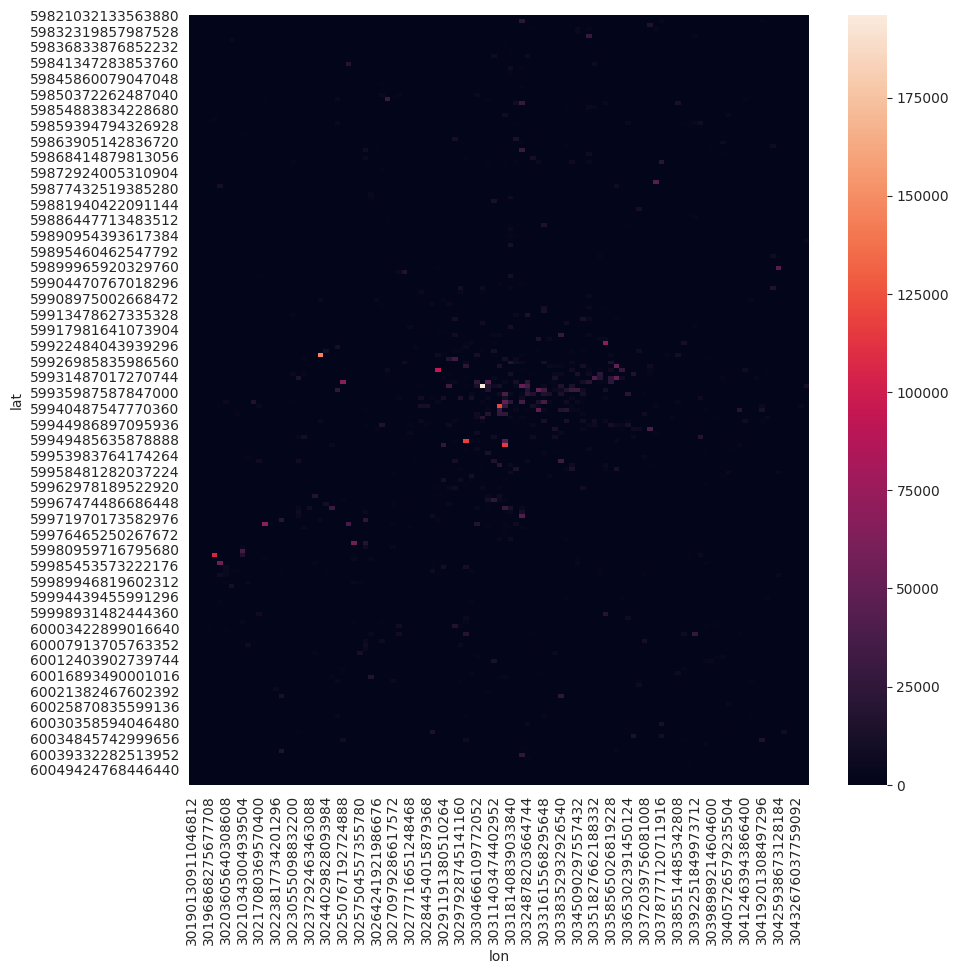

In [53]:
sns.heatmap(df_heatmap_merged_sns)